In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

# Exercise 1: Direct PCA method

## a,b) Covarience matrix and displaying

In [39]:
def get_covariance_matrix(in_points):
    mu = np.zeros(2)
    mu[0] = np.mean(in_points[:, 0]) #np.sum(in_points[:, 0]) / in_points.shape[0]
    mu[1] = np.mean(in_points[:, 1])
    centered = in_points - mu
    covariance = (1 / (in_points.shape[0] - 1)) * centered.T @ centered
    return mu, covariance

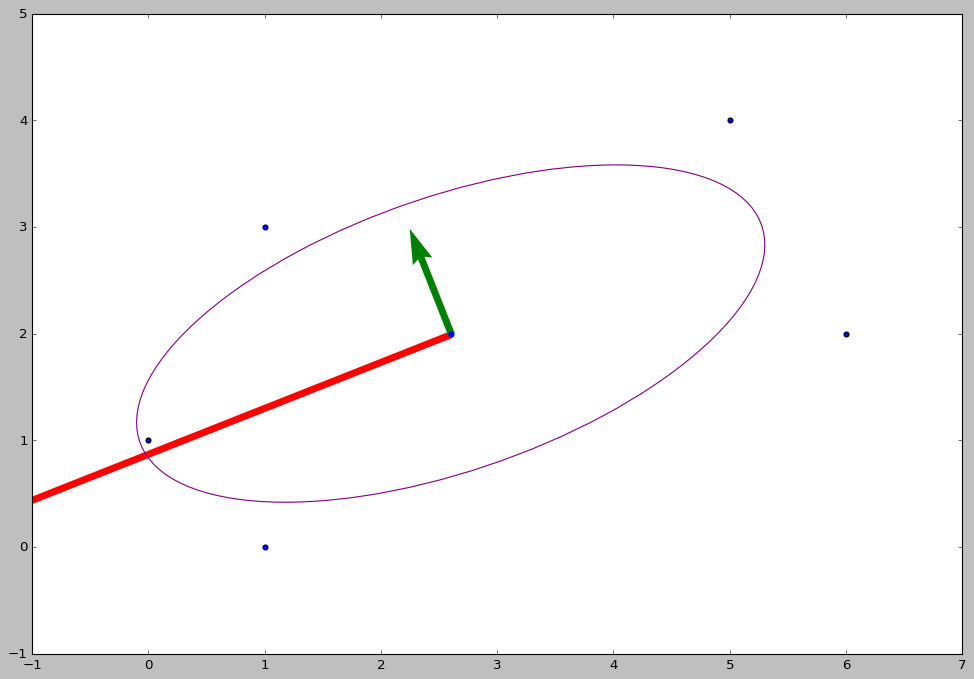

In [40]:
from a6_utils import drawEllipse

points = np.loadtxt('data/points.txt')
points_mean, points_c = get_covariance_matrix(points)
points_U, points_S, _ = np.linalg.svd(points_c)

plt.figure(figsize=(15, 10))
plt.quiver(points_mean[0], points_mean[1], points_U[0, 0], points_U[1, 0], scale=points_S[1], color='red')
plt.quiver(points_mean[0], points_mean[1], points_U[0, 1], points_U[1, 1], scale=points_S[0], color='green')
plt.scatter(points_mean[0], points_mean[1], color='blue')
plt.scatter(points[:,0], points[:,1])
drawEllipse(points_mean, points_c)
plt.show()

## c) Cumulative graph

In [10]:
# points_S_norm = points_S / np.linalg.norm(points_S)

## d) Single vector subspace

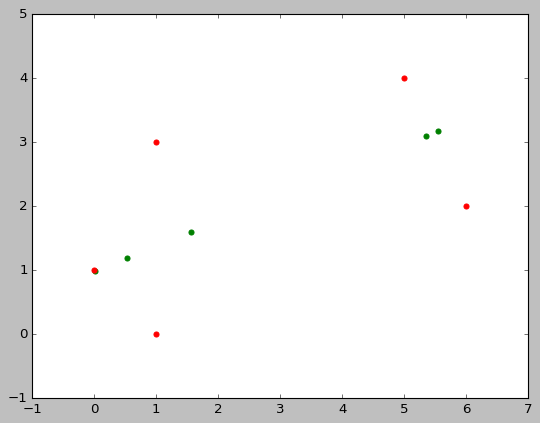

In [11]:
def PCA_d(in_points):
    mean, c = get_covariance_matrix(in_points)
    U, _, _ = np.linalg.svd(c)
    points = np.copy(in_points)
    for i, p in enumerate(points):
        points[i] = U.T @ (p - mean)
    
    U[:,1] = 0
    for i, p in enumerate(points):
        points[i] = (U @ p) + mean  # other direction 

    return points

pcad_points = PCA_d(points)
plt.scatter(pcad_points[:,0], pcad_points[:,1], color='green')
plt.scatter(points[:,0], points[:,1], color='red')
plt.show()

## e) Distance

In [15]:
def shortestDistance(pts, pt):
    dist_min = -1
    dist_ind = 0
    for i, p in enumerate(pts):
        dist = np.linalg.norm(p - pt)
        if i == 0 or dist < dist_min:
            dist_min = dist
            dist_ind = i
    return dist_ind

Euclid: points[2]: [5. 4.]
PCA:    pca_e_points[1]: [4.47790158 4.02684711]


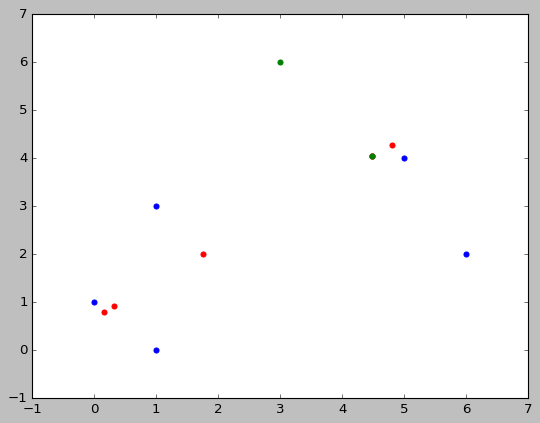

In [31]:
qpt = [3, 6]
short_ind = shortestDistance(points, qpt)
print(f"Euclid: points[{short_ind}]: {points[short_ind]}")
pca_e_points = PCA_d(np.vstack([points, qpt]))
short_ind = shortestDistance(pca_e_points[:5], qpt)
print(f"PCA:    pca_e_points[{short_ind}]: {pca_e_points[short_ind]}")

plt.scatter(points[:,0], points[:,1], color='blue')
plt.scatter(pca_e_points[:,0], pca_e_points[:,1], color='red')
plt.scatter(pca_e_points[5,0], pca_e_points[5,1], color='green')
plt.scatter(qpt[0], qpt[1], color='green')
plt.show()

# Exercise 2: The dual PCA method

## a) Dual PCA

In [58]:
def get_covariance_matrix_dual(in_points):
    mu = np.zeros(2)
    mu[0] = np.mean(in_points[:, 0])
    mu[1] = np.mean(in_points[:, 1])
    centered = in_points - mu
    covariance = (1 / (in_points.shape[1] - 1)) * centered.T @ centered
    return mu, covariance

def dual_PCA(in_points):
    mu = np.zeros(2)
    mu[0] = np.mean(in_points[:, 0])
    mu[1] = np.mean(in_points[:, 1])
    centered = in_points - mu
    covariance = (1 / (in_points.shape[1] - 1)) * centered @ centered.T

    U, S, _ = np.linalg.svd(covariance)
    U = (centered.T @ U) * np.sqrt(1 / S * (in_points.shape[1] - 1))
    return mu, U

In [59]:
dual_pca_mu, dual_pca_U = dual_PCA(points)
print(dual_pca_U)

[[ 9.29929353e-01 -3.67738219e-01 -1.87973464e-08  1.11739298e-08
  -1.92673835e-08]
 [ 3.67738219e-01  9.29929353e-01  3.52450244e-09 -1.67608946e-08
   0.00000000e+00]]


## b) Dual PCA example

In [84]:
def test_dualPCA(in_points, mean, U):
    points = np.copy(in_points)

    for i, p in enumerate(points):
        points[i] = U.T @ (p - mean)
    
    for i, p in enumerate(points):
        points[i] = (U @ p) + mean  # other direction 

    return points

In [85]:
test_dualPCA(points, dual_pca_mu, dual_pca_U)

ValueError: could not broadcast input array from shape (5,) into shape (2,)